In [100]:
import numpy as np
import time
import pickle
import pandas as pd
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report,roc_curve,auc, f1_score, plot_roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import plotly.graph_objects as go
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from tqdm import tqdm
from zipfile import ZipFile
from IPython.display import display
import modules.processor as Processor
import modules.utils as Utils
import modules.model as Model
import modules.plot as Plot

In [17]:
train = pd.read_csv("../data/split-data/without-mhc/train/train.csv")
test01 = pd.read_csv("../data/split-data/without-mhc/test/test01.csv")

train_mhc = pd.read_csv("../data/split-data/with-mhc/train/train.csv")
test01_mhc = pd.read_csv("../data/split-data/with-mhc/test/test01.csv")

In [31]:
sp_data = Processor.split_dataframe_by_position(train, 2)
# sp_data[1]

X_train = train.iloc[:, :2]
y_train = train.iloc[:, 2:]

X_test01 = test01.iloc[:, :2]
y_test01 = test01.iloc[:, 2:]

X_train_mhc = train_mhc.iloc[:, :2]
y_train_mhc = train_mhc.iloc[:, 2:]

X_test01_mhc = test01_mhc.iloc[:, :2]
y_test01_mhc = test01_mhc.iloc[:, 2:]

In [21]:
clf_sm = RandomUnderSampler(random_state=42)
X_res, y_res = clf_sm.fit_resample(X_train, y_train)

In [12]:
# Without MHC
pX_res = Processor.data_representation(X_res)
py_res = y_res.copy()

pX_res.to_csv("../data/convert-data/without-mhc/res/X.csv", index=False)
py_res.to_csv("../data/convert-data/without-mhc/res/y.csv", index=False)

# With MHC
pX_test01 = Processor.data_representation(X_test01)
py_test01 = y_test01.copy()

pX_test01.to_csv("../data/converted-data/with_mhc/test/pX_test01.csv", index=False)
py_test01.to_csv("../data/converted-data/with_mhc/test/py_test01.csv", index=False)

In [33]:
pX_res = pd.read_csv("../data/convert-data/without-mhc/res/X.csv")
py_res = pd.read_csv("../data/convert-data/without-mhc/res/y.csv")

pX_test01 = pd.read_csv("../data/convert-data/without-mhc/test/test01/X.csv")
py_test01 = pd.read_csv("../data/convert-data/without-mhc/test/test01/y.csv")

pX_res_mhc = pd.read_csv("../data/convert-data/with-mhc/res/X.csv")
py_res_mhc = pd.read_csv("../data/convert-data/with-mhc/res/y.csv")

pX_test01_mhc = pd.read_csv("../data/convert-data/with-mhc/test/test01/X.csv")
py_test01_mhc = pd.read_csv("../data/convert-data/with-mhc/test/test01/y.csv")

In [34]:
lst_models = [
    ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1)),
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

original_models = Model.train(lst_models, pX_res, np.ravel(py_res), cv)
original_models_mhc = Model.train(lst_models, pX_res_mhc, np.ravel(py_res_mhc), cv)

	Model Random Forest has been trained in 7.54 seconds
	Model Random Forest has been trained in 37.83 seconds


In [35]:
lst_tunning_models = [
    ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1), {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ["auto", "sqrt", "log2", 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}),
]

In [ ]:
lst_tunning_models = Model.trainTunningModel(lst_models, pX_res, np.ravel(py_res), cv)

In [36]:
lst_tunning_models = [
    ('Random Forest', RandomForestClassifier(bootstrap=False, max_depth=90, max_features=5,
                         n_estimators=400, n_jobs=-1, random_state=42))]

lst_tunning_models_mhc = [
    ('Random Forest',RandomForestClassifier(bootstrap=False, max_depth=90, max_features='auto',
                         min_samples_split=10, n_estimators=600, n_jobs=-1, random_state=42))]

In [37]:
best_models = Model.evaluation(lst_tunning_models, pX_res, np.ravel(py_res), pX_test01, py_test01)
best_models_mhc = Model.evaluation(lst_tunning_models_mhc, pX_res_mhc, np.ravel(py_res_mhc), pX_test01_mhc, py_test01_mhc)

100%|██████████| 1/1 [00:35<00:00, 35.72s/it]


In [49]:
Plot.evaluationGroupedBarChart(original_models, 3)

In [93]:
class epitcrModel:
    def __init__(self, pmodel, pX, py):
        self.model = pmodel
        self.model.fit(pX, py)
    
    def predict(self, pnew_data):
        yhat_class = self.model.predict(pnew_data)
        return yhat_class 

    
    def info(self):
        print(self.model)
    
    def rocAuc(self, X, y_true):
        ax = plt.subplot()
        n = X.shape[0]
        mean_fpr = np.linspace(0, 1, n)
        tprs = []
        aucs = []
        viz = plot_roc_curve(self.model, X, y_true,
                                name='Random Forest',
                                alpha=.3, lw=2, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="ROC curve comparison")
        ax.legend(loc="lower right")
        plt.show()
    
    def predict_proba(self, pnew_data):
        yhat_class = self.model.predict_proba(pnew_data)
        return yhat_class 

In [94]:
rf_tcr = lst_tunning_models[0][1]
model_rf = epitcrModel(rf_tcr, pX_res, np.ravel(py_res))
model_rf.info()

rf_tcr_mhc = lst_tunning_models_mhc[0][1]
model_rf_mhc = epitcrModel(rf_tcr_mhc, pX_res_mhc, np.ravel(py_res_mhc))
model_rf_mhc.info()

RandomForestClassifier(bootstrap=False, max_depth=90, max_features=5,
                       n_estimators=400, n_jobs=-1, random_state=42)
RandomForestClassifier(bootstrap=False, max_depth=90, max_features='auto',
                       min_samples_split=10, n_estimators=600, n_jobs=-1,
                       random_state=42)


In [57]:
y_rf_test01_proba = model_rf.predict_proba(pX_test01)
df_test01 = pd.DataFrame(data = y_rf_test01_proba, columns = ["tmp", "predict_proba"])

y_rf_test01_proba_mhc = model_rf_mhc.predict_proba(pX_test01_mhc)
df_test01_mhc = pd.DataFrame(data = y_rf_test01_proba_mhc, columns = ["tmp", "predict_proba"])

In [58]:
df_test = df_test01.iloc[:, 1:]
df_test_mhc = df_test01_mhc.iloc[:, 1:]

In [60]:
df_prob_test01 = pd.concat([test01, df_test01], axis=1)
df_prob_test01['binder_pred'] = np.where(df_prob_test01['predict_proba'] >= 0.5, 1, 0)
df_prob_test01.to_csv("../data/predict-data/without-mhc/test01_predict_proba.csv", index=False)

df_prob_test01_mhc = pd.concat([test01_mhc, df_test01_mhc], axis=1)
df_prob_test01_mhc['binder_pred'] = np.where(df_prob_test01_mhc['predict_proba'] >= 0.5, 1, 0)
df_prob_test01_mhc.to_csv("../data/predict-data/with-mhc/test01_predict_proba.csv", index=False)

In [64]:
y_test01 = df_prob_test01["binder"].to_numpy()
y_test01_pred = df_prob_test01["binder_pred"].to_numpy()

y_test01_mhc = df_prob_test01_mhc["binder"].to_numpy()
y_test01_pred_mhc = df_prob_test01_mhc["binder_pred"].to_numpy()

In [95]:
# Model.confusionMatrix(y_test01, y_test01_pred)
# tn, fp, fn, tp = confusion_matrix(y_test01, y_test01_pred).ravel()
# print('Sensitivity (TPR): ', tp/(tp+fn))
# print('Specificity (TNR): ', tn/(tn+fp))


# Model.confusionMatrix(y_test01_mhc, y_test01_pred_mhc)
# tn, fp, fn, tp = confusion_matrix(y_test01_mhc, y_test01_pred_mhc).ravel()
# print('Sensitivity (TPR): ', tp/(tp+fn))
# print('Specificity (TNR): ', tn/(tn+fp))

              precision    recall  f1-score   support

  Non-binder       0.99      0.90      0.95     66280
      Binder       0.49      0.94      0.64      6628

    accuracy                           0.91     72908
   macro avg       0.74      0.92      0.80     72908
weighted avg       0.95      0.91      0.92     72908



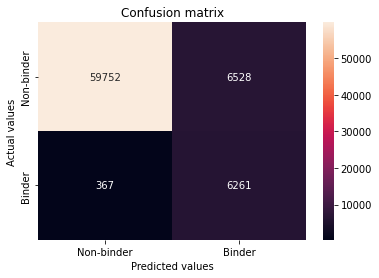

RandomForestClassifier(bootstrap=False, max_depth=90, max_features=5,
                       n_estimators=400, n_jobs=-1, random_state=42)
Accuracy score        :  [0.90542876]
F1 score              :  [0.6448988]
AUC                   :  0.9773357455741793
Sensitivity (TPR)     :  0.9446288473144236
Specificity (TNR)     :  0.9015087507543754
classification report :
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     66280
           1       0.49      0.94      0.64      6628

    accuracy                           0.91     72908
   macro avg       0.74      0.92      0.80     72908
weighted avg       0.95      0.91      0.92     72908



In [81]:
accuracy_rf_test01, classify_metrics_rf_test01, fpr_rf_test01, tpr_rf_test01, auc_score_rf_test01, f1_rf_test01 = Model.model_run(rf_tcr, pX_res, py_res, pX_test01, py_test01)

              precision    recall  f1-score   support

  Non-binder       0.99      0.88      0.93     66820
      Binder       0.44      0.94      0.60      6682

    accuracy                           0.88     73502
   macro avg       0.71      0.91      0.76     73502
weighted avg       0.94      0.88      0.90     73502



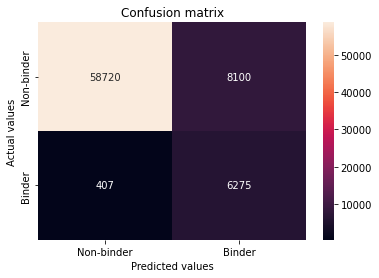

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='auto',
                       min_samples_split=10, n_estimators=600, n_jobs=-1,
                       random_state=42)
Accuracy score        :  [0.88426165]
F1 score              :  [0.59600133]
AUC                   :  0.9658551867669342
Sensitivity (TPR)     :  0.9390900927865908
Specificity (TNR)     :  0.8787788087398982
classification report :
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     66820
           1       0.44      0.94      0.60      6682

    accuracy                           0.88     73502
   macro avg       0.71      0.91      0.76     73502
weighted avg       0.94      0.88      0.90     73502



In [83]:
accuracy_rf_test01_mhc, classify_metrics_rf_test01_mhc, fpr_rf_test01_mhc, tpr_rf_test01_mhc, auc_score_rf_test01_mhc, f1_rf_test01_mhc = Model.model_run(rf_tcr_mhc, pX_res_mhc, py_res_mhc, pX_test01_mhc, py_test01_mhc)

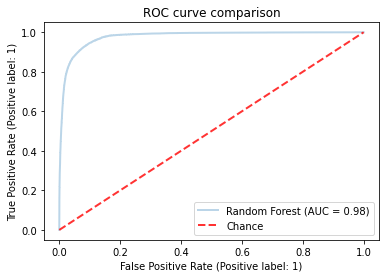

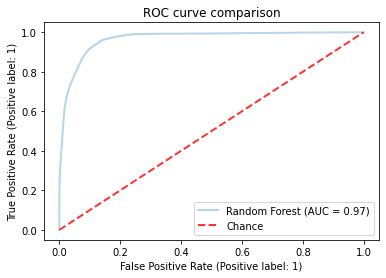

In [96]:
model_rf.rocAuc(pX_test01, py_test01)

model_rf_mhc.rocAuc(pX_test01_mhc, py_test01_mhc) 

In [99]:
Model.saveByPickle(model_rf, "./models/rdforest-model.pickle")
pickled_model_rf = pickle.load(open('./models/rdforest-model.pickle', 'rb'))

Model.saveByPickle(model_rf_mhc, "./models/rdforest-model-mhc.pickle")
pickled_model_rf_mhc = pickle.load(open('./models/rdforest-model-mhc.pickle', 'rb'))

<__main__.epitcrModel object at 0x156bc1c70> has been saved at ./models/rdforest-model.pickle.
<__main__.epitcrModel object at 0x156b43b50> has been saved at ./models/rdforest-model-mhc.pickle.
